## Reference

https://github.com/LukeDitria/pytorch_tutorials/blob/main/section07_autoencoders/solutions/Pytorch1_Autoencoders_Solutions.ipynb

## Summary

This code uses an autoencoder for denoising. It applies convolutional downsampling and transposed-convolution upsampling to compress and reconstruct images. The network is explicitly trained to remove noise by mapping noisy inputs back to clean targets. It is not a generative model, so sampling or generating new images from random latent vectors does not work well.

## Note

When an autoencoder is used for feature reduction, the model is trained by feeding in clean images and computing the loss against those same clean images. The latent space can be used for downstream tasks like classification, but it is not suitable for generative use. See Variational-Autoencoders for generative use.



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as Datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models as models
import torchvision.utils as vutils

import os
import random
import numpy as np
import math
from IPython.display import clear_output
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import trange, tqdm


In [2]:
batch_size = 64

# Define learning rate
lr = 1e-4

# Number of Training epochs
nepoch = 10

# Dataset location
root = "../datasets"

# Scale for the added image noise
noise_scale = 0.3


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Using device:", device)


Using device: mps


In [4]:
# Define our transform
# We'll upsample the images to 32x32 as it's easier to contruct our network
transform = transforms.Compose([
            transforms.Resize(32),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])])

train_set = Datasets.MNIST(root=root, train=True, transform=transform, download=True)
train_loader = DataLoader(train_set, batch_size=batch_size,shuffle=True, num_workers=4)

test_set = Datasets.MNIST(root=root, train=False, transform=transform, download=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)


In [5]:
# We split up our network into two parts, the Encoder and the Decoder
class Encoder(nn.Module):
    def __init__(self, channels, ch=32, z=32):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(channels, ch, 3, 2, 1)
        self.bn1 = nn.BatchNorm2d(ch)
        self.conv2 = nn.Conv2d(ch, 2 * ch, 3, 2, 1)
        self.bn2 = nn.BatchNorm2d(2 * ch)
        self.conv3 = nn.Conv2d(2 * ch, 4 * ch, 3, 2, 1)
        self.bn3 = nn.BatchNorm2d(4 * ch)

        self.conv_out = nn.Conv2d(4 * ch, z, 4, 1)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        return self.conv_out(x)
    
class Decoder(nn.Module):
    def __init__(self, channels, ch = 32, z = 32):
        super(Decoder, self).__init__()
        
        self.conv1 = nn.ConvTranspose2d(z, 4 * ch, 4, 1)
        self.bn1 = nn.BatchNorm2d(4 * ch)
        self.conv2 = nn.ConvTranspose2d(4 * ch, 2 * ch, 3, 2, 1, 1)
        self.bn2 = nn.BatchNorm2d(2 * ch)
        self.conv3 = nn.ConvTranspose2d(2 * ch, ch, 3, 2, 1, 1)
        self.bn3 = nn.BatchNorm2d(ch)
        self.conv4 = nn.ConvTranspose2d(ch, ch, 3, 2, 1, 1)
        self.bn4 = nn.BatchNorm2d(ch)

        self.conv_out = nn.Conv2d(ch, channels, 3, 1, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))

        return torch.tanh(self.conv_out(x))
    
class AE(nn.Module):
    def __init__(self, channel_in, ch=16, z=32):
        super(AE, self).__init__()
        self.encoder = Encoder(channels=channel_in, ch=ch, z=z)
        self.decoder = Decoder(channels=channel_in, ch=ch, z=z)

    def forward(self, x):
        encoding = self.encoder(x)
        x = self.decoder(encoding)
        return x, encoding


In [6]:
# Get a test image
dataiter = iter(test_loader)
# Fixed version issue
test_images = next(dataiter)[0]
# View the shape
test_images.shape


torch.Size([64, 1, 32, 32])

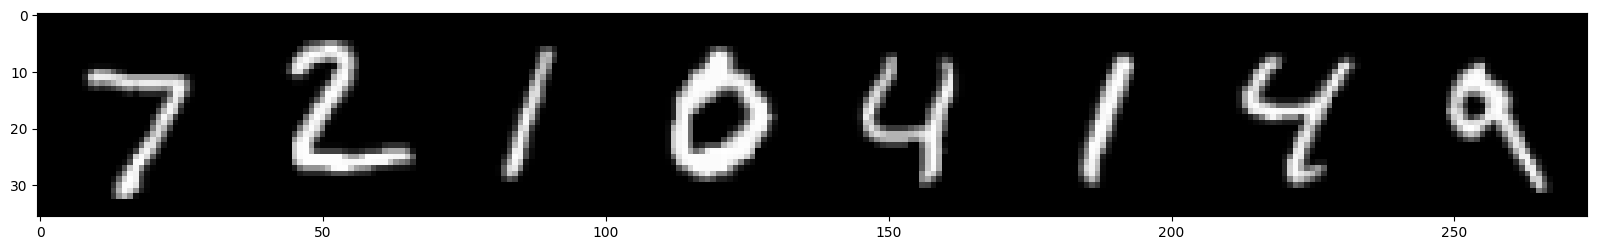

In [7]:
# Visualize the data!!!
plt.figure(figsize = (20,10))
out = vutils.make_grid(test_images[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))


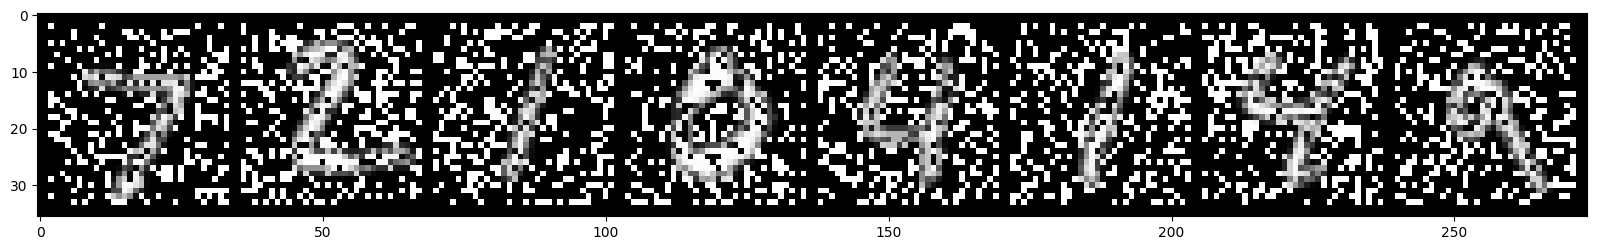

In [8]:
# Visualize the data!!!
plt.figure(figsize = (20, 10))
random_sample = (torch.bernoulli((1 - noise_scale) * torch.ones_like(test_images)) * 2) - 1
noisy_test_img = random_sample * test_images

out = vutils.make_grid(noisy_test_img[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))


In [9]:
# The size of the Latent Vector
latent_size = 128

# Create our network
ae_net = AE(channel_in=1, z=latent_size).to(device)

# Setup optimizer
optimizer = optim.Adam(ae_net.parameters(), lr=lr)

# MSE loss for reconstruction!
loss_func = nn.MSELoss()

loss_log = []
train_loss = 0


In [10]:
# Pass through a test image to make sure everything is working
recon_data, encoding = ae_net(test_images.to(device))

# View the Latent vector shape
encoding.shape


torch.Size([64, 128, 1, 1])

In [11]:
pbar = trange(0, nepoch, leave=False, desc="Epoch")    
for epoch in pbar:
    pbar.set_postfix_str('Loss: %.4f' % (train_loss/len(train_loader)))
    train_loss = 0
    for i, data in enumerate(tqdm(train_loader, leave=False, desc="Training")):

        image = data[0].to(device)
        
        random_sample = (torch.bernoulli((1 - noise_scale) * torch.ones_like(image)) * 2) - 1
        noisy_img = random_sample * image
        
        # Forward pass the image in the data tuple
        recon_data, _ = ae_net(noisy_img)
        
        # Calculate the MSE loss
        loss = loss_func(recon_data, image)
        
        # Log the loss
        loss_log.append(loss.item())
        train_loss += loss.item()
        
        # Take a training step
        ae_net.zero_grad()
        loss.backward()
        optimizer.step()


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

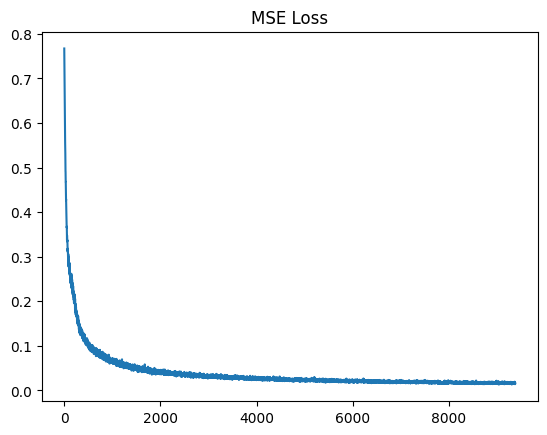

In [12]:
_ = plt.plot(loss_log)
_ = plt.title("MSE Loss")


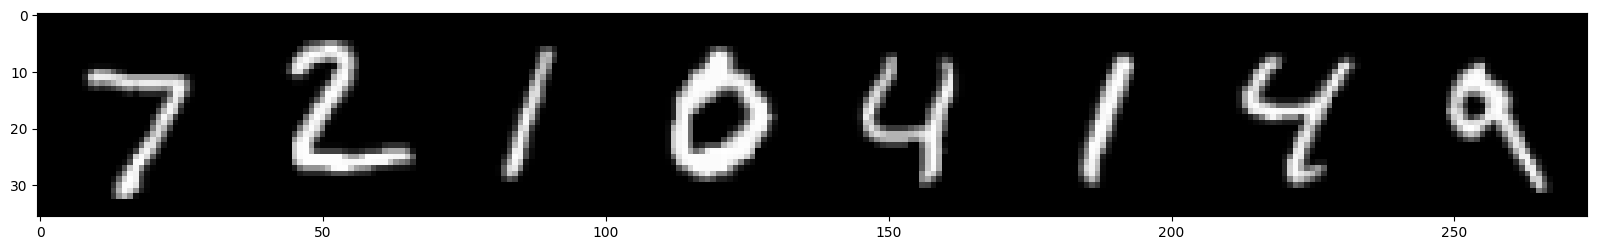

In [13]:
# Ground Truth
plt.figure(figsize = (20,10))
out = vutils.make_grid(test_images[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))


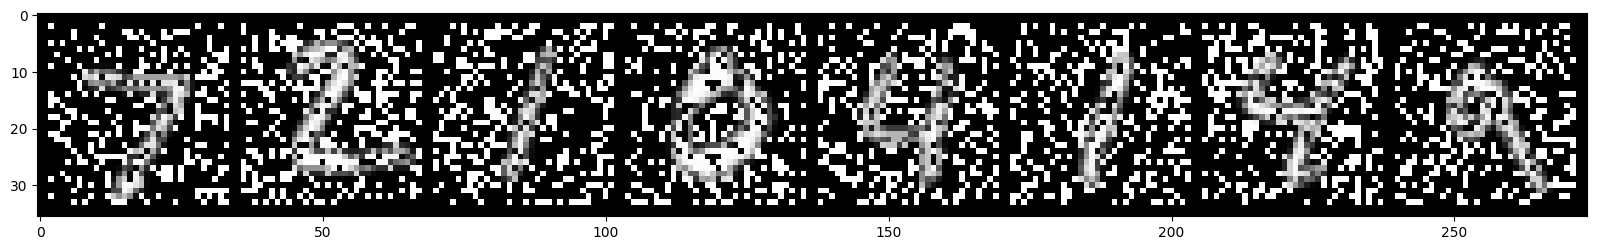

In [14]:
# Noisy Input
plt.figure(figsize = (20,10))
out = vutils.make_grid(noisy_test_img[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))


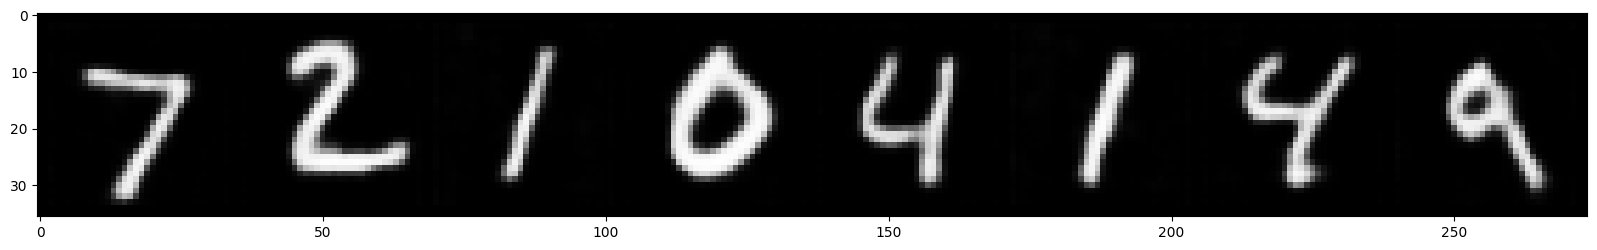

In [15]:
# Reconstruction
plt.figure(figsize = (20,10))
recon_data, encoding = ae_net(noisy_test_img.to(device))
out = vutils.make_grid(recon_data.detach().cpu()[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))


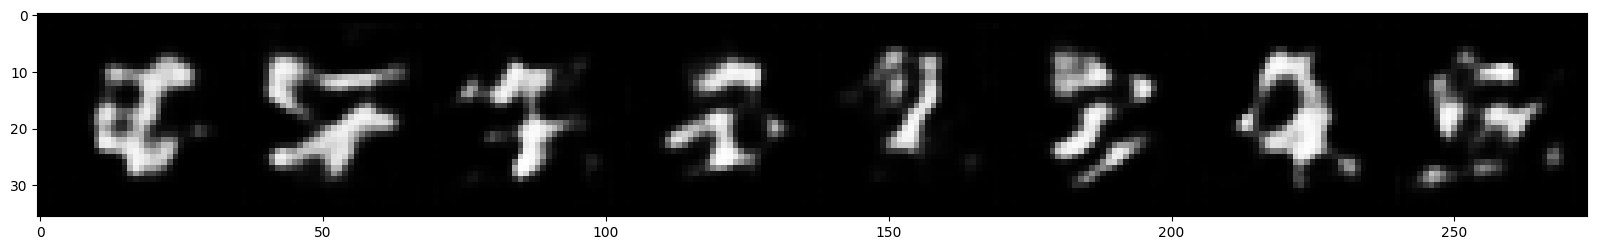

In [ ]:
# Reconstruction
plt.figure(figsize = (20,10))
recon_data = ae_net.decoder(encoding.std(0, keepdims=True) * torch.randn_like(encoding) + encoding.mean(0, keepdims=True))
out = vutils.make_grid(recon_data.detach().cpu()[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))
